# [IT8303] AI-Human Interface: Fashion-MNIST Convolutional Neural Network (CNN)

## Table of Contents
1. [Libraries](#1)
2. [Exploratory Data Analysis](#2)
3. [Data Pre-Processing & Augmentation](#3)
4. [Model Development](#4)
5. [Hyperparameter Tuning](#5)
6. [Conclusion](#6)

__Introduction__  
This project explores the application of a Convolutional Neural Network (CNN) to the Fashion-MNIST dataset, a widely-used benchmark for image classification tasks in deep learning. Fashion-MNIST consists of 70,000 grayscale images, each sized 28x28 pixels, representing clothing items across 10 distinct categories, such as T-shirts, dresses, and sandals. The goal of this analysis is to develop a CNN model capable of accurately predicting the category of a given clothing item based solely on its image.

This project not only demonstrates the applications of deep learning neural networks to image recognition and classification, but it also serves as an opportunity to explore techniques for image feature engineering and developing model performance monitoring systems for practical deep learning workflows.

__Datasets used__  
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)

# 1. Load Libraries <a id='1'></a>

In [1]:
!pip -q install loguru
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
import warnings
from datetime import datetime as dt

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.utils import plot_model
from loguru import logger
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

%load_ext tensorboard
import datetime
import os

# 2. Exploratory Data Analysis <a id='2'></a>

In [3]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Here, we visualise the class distribution in the training dataset to detect potential imbalances. Class imbalances can negatively impact model training, leading to bias toward over-represented classes. Insufficient samples from under-represented classes hinder the model’s ability to learn patterns effectively, compromising overall performance.

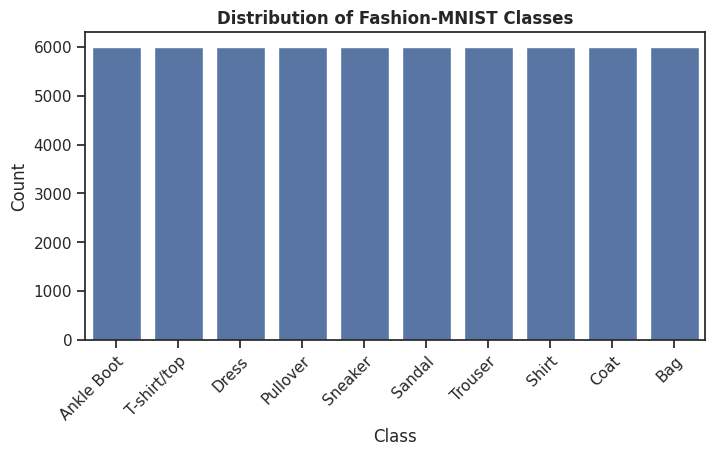

In [4]:
# Visualise the counts of each category
sns.set_theme(style="ticks")

counts_series = pd.Series(y_train).value_counts()
labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
counts_series.index = counts_series.index.map(labels)

plt.figure(figsize=(8, 4))
sns.barplot(counts_series)
plt.title("Distribution of Fashion-MNIST Classes", fontweight="bold")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

Images are visualized to assess their quality and identify patterns. This analysis helps determine:
- <b>Need for augmentation</b>: To enhance the dataset by introducing variability. Since the images are uniform and properly oriented, augmentation can generalize the model to diverse inputs which will better simulate real-world conditions.
- <b>Filter size</b>: Fashion-MNIST’s small (28x28) images suggest that a 3x3 filter is sufficient.
- <b>Padding requirement</b>: Necessary to retain spatial information, especially for border images.

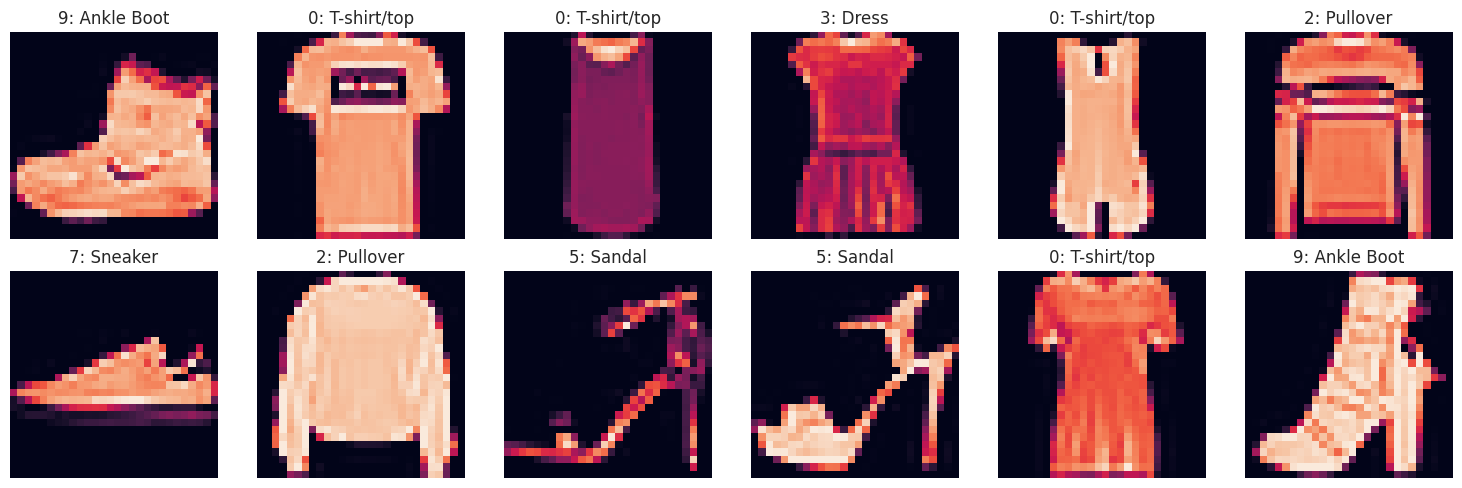

In [5]:
# Plot first few images for inspection
plt.figure(figsize=(15, 5))
sns.set_theme(style="white")

for i in range(12):
    plt.subplot(2, 6, i + 1)
    image = x_train[i]
    plt.imshow(image)
    plt.title(f"{y_train[i]}: {labels[y_train[i]]}")
    plt.axis("off")

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

# 3. Data Pre-Processing & Augmentation <a id='3'></a>

Prior to training the model, the data is preprocessed by scaling to ensure pixel values are normalized for consistency and to improve training stability. In addition, the images are reshaped to match the CNN's input requirements (e.g., adding channels for grayscale images in the Fashion-MNIST dataset).

The training dataset was further divided into a training set and a validation set to enable performance evaluation during the training process. This ensures the model’s ability to generalise is assessed by monitoring its performance on unseen data while training.

In [6]:
# Min-max scaling (min=0, max=255) to 0-1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape images to 28, 28, 1
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

The following transformations were applied for data augmentation to enhance the model’s robustness and generalisation while ensuring that the resultant images were still realistic/usable:
- __Rotation__: Randomly rotate images within a range of ±20 degrees.
- __Shifting__: Translate images horizontally and vertically by up to ±10% of their dimensions.
- __Zooming__: Adjust the zoom factor by ±5%.
- __Flipping__: Apply random horizontal and vertical flips.
- __Fill Mode__: Preserve image integrity by filling missing pixels with values from the nearest neighboring pixels where applicable.

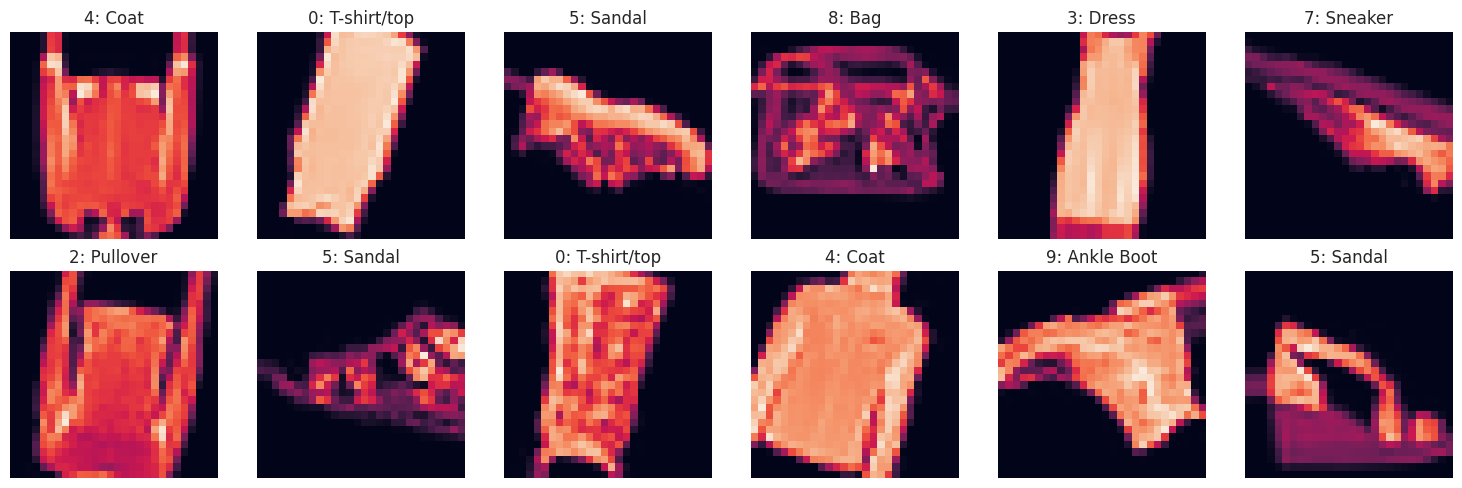

In [7]:
# Instantiate data augmenter to generate images
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
)

data_gen.fit(X_train)

# Inspect some images to assess augmentation
plt.figure(figsize=(15, 5))

for X_batch, y_batch in data_gen.flow(X_train, y_train, batch_size=12):
    for i in range(12):
        plt.subplot(2, 6, i + 1)
        image = X_batch[i]
        plt.imshow(image)
        plt.title(f"{y_batch[i]}: {labels[y_batch[i]]}")
        plt.axis("off")
    break

plt.tight_layout()
plt.show()

# 4. Model Development <a id='4'></a>

## Simple CNN Baseline

To support model experimentation and development, a simple baseline CNN model was constructed with the following architecture:
- A single convolutional layer with 32 filters and 3x3 kernels.
- Two dense layers: one with 64 neurons and a final layer with 10 neurons (corresponding to the 10 output classes).
- ReLU activation was applied to all layers except the final layer, which used softmax activation to predict class probabilities.
- HeNormal initializers were used to maintain weight variance across layers, especially since ReLU activations were used which may 'kill' neurons by outputting 0, preventing backpropogation.
- MaxPooling was included to reduce spatial dimensions.

The model’s performance was evaluated using the validation set during training and the test set after training. The following metrics were utilised:
- Overall accuracy;
- Classification report, including precision, recall, and F1-score for each class;
- Confusion matrix to analyse prediction errors; and
- Accuracy and loss trends visualised by epoch to monitor training progress.

In [ ]:
# Define simple baseline model with one convolutional layer and two fully-connected layers
baseline_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",  # Use HeNormal initializer which is designed for ReLU activations
            padding="same",
            input_shape=(28, 28, 1),
        ),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

# Compile model
baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",  # y_train is an array of integers, use sparse over non-sparse categorical crossentropy loss
    metrics=["accuracy"],
)

# Log for tensorboard monitoring (optional)
current_time = dt.now().strftime("%d %b %Y %H:%M")
log_dir = "logs/model_baseline/" + current_time
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Fit model using image generator
logger.debug("Training baseline CNN model")
baseline_history = baseline_model.fit(
    data_gen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[tb_callback],
)
logger.success("CNN model successfully trained!")

2024-11-29 12:25:44.215 | DEBUG    | __main__:<cell line: 32>:32 - Training baseline CNN model


Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.6246 - loss: 1.0175 - val_accuracy: 0.7732 - val_loss: 0.6290
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7579 - loss: 0.6474 - val_accuracy: 0.7874 - val_loss: 0.5879
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.7752 - loss: 0.5974 - val_accuracy: 0.8105 - val_loss: 0.5394
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.7792 - loss: 0.5782 - val_accuracy: 0.8029 - val_loss: 0.5543
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7939 - loss: 0.5495 - val_accuracy: 0.8166 - val_loss: 0.5240
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8018 - loss: 0.5286 - val_accuracy: 0.8210 - val_loss: 0.5017
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8051 - loss: 0.5310 - val_accuracy: 0.8157 - val_loss: 0.5151
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8085 -

2024-11-29 12:35:47.989 | SUCCESS  | __main__:<cell line: 39>:39 - CNN model successfully trained!


In [9]:
# Evaluate model results using tensorbord (optional)
# %tensorboard --logdir logs/model_fit

As we will be building and evaluating several CNN models, here, we defined a custom function that will help us with:
- Model evaluation against the test dataset to measure performance.
- Plot relevant metrics and graphs, including:
  - Training and validation accuracy and loss by epoch.
  - Confusion matrix to visualise classification performance.
  - Sklearn classification report (precision, recall, F1-score).

In [10]:
# Define function to evaluate trained models based on model history and validation agest specified test set
def evaluate_model(model, history, x_test, y_test, num_classes=10):
    """
    Evaluates the performance of a trained CNN model and generates relevant metrics and plots

    Parameters:
        model: Trained Keras model
        history: Training history returned by model.fit()
        x_test: Test features
        y_test: Test labels
        num_classes: Number of classes in the classification task (default: 10)

    Returns:
        None
    """
    logger.debug("Evaluating model...")

    # Evaluate accuracy on the test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.5f}")

    # Generate predictions
    y_pred = model.predict(x_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Print sklearn classification report
    report = classification_report(y_test, y_pred_classes)
    print(f"\nClassification Report:\n {report}")

    plt.figure(figsize=(10, 8))

    # Confusion matrix
    plt.subplot(2, 1, 1)
    cm = tf.math.confusion_matrix(
        y_test, y_pred_classes, num_classes=num_classes
    ).numpy()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Plot training and validation accuracy and loss
    acc = history.history["accuracy"]
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history["loss"]
    val_loss = history.history.get("val_loss", [])
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, acc, label="Training Accuracy")
    if val_acc:
        plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs, loss, label="Training Loss")
    if val_loss:
        plt.plot(epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

2024-11-29 12:35:48.019 | DEBUG    | __main__:evaluate_model:16 - Evaluating model...


Test accuracy: 0.83140

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.67      0.77      1000
           1       0.96      0.96      0.96      1000
           2       0.85      0.53      0.66      1000
           3       0.81      0.86      0.83      1000
           4       0.81      0.71      0.76      1000
           5       0.93      0.98      0.95      1000
           6       0.47      0.79      0.59      1000
           7       0.94      0.89      0.92      1000
           8       0.95      0.97      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.83     10000
   macro avg       0.86      0.83      0.83     10000
weighted avg       0.86      0.83      0.83     10000



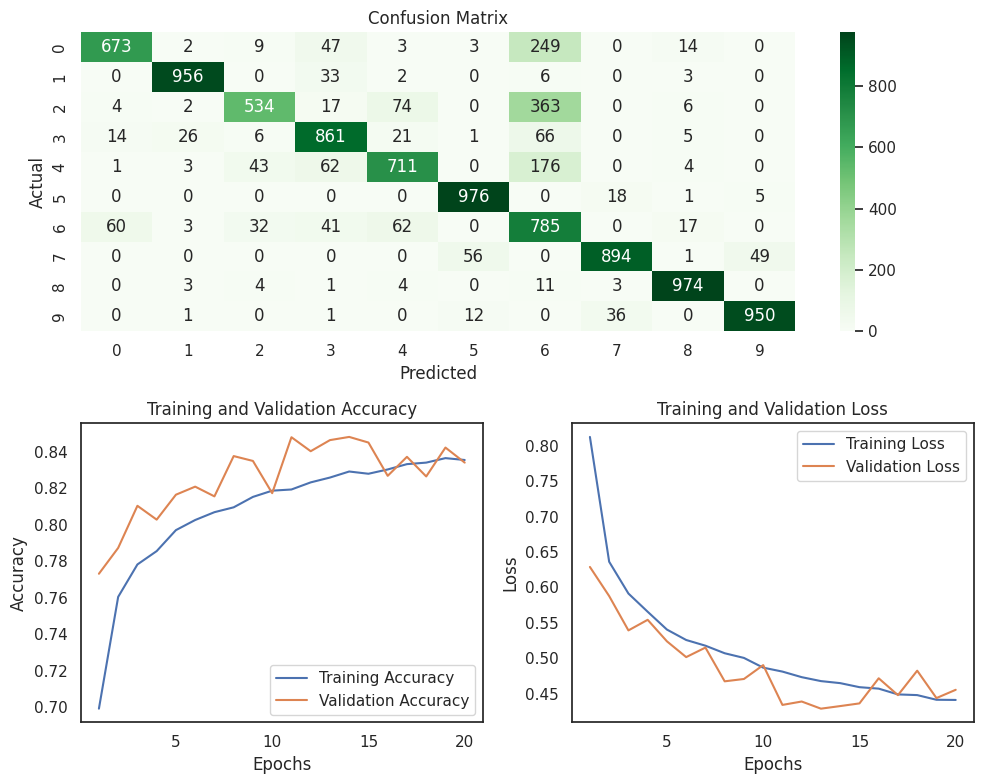

In [ ]:
# Evaluate baseline
evaluate_model(
    model=baseline_model,
    history=baseline_history,
    x_test=x_test,
    y_test=y_test,
    num_classes=10,
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,207,328 (4.61 MB)

 Trainable params: 402,442 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 804,886 (3.07 MB)

None


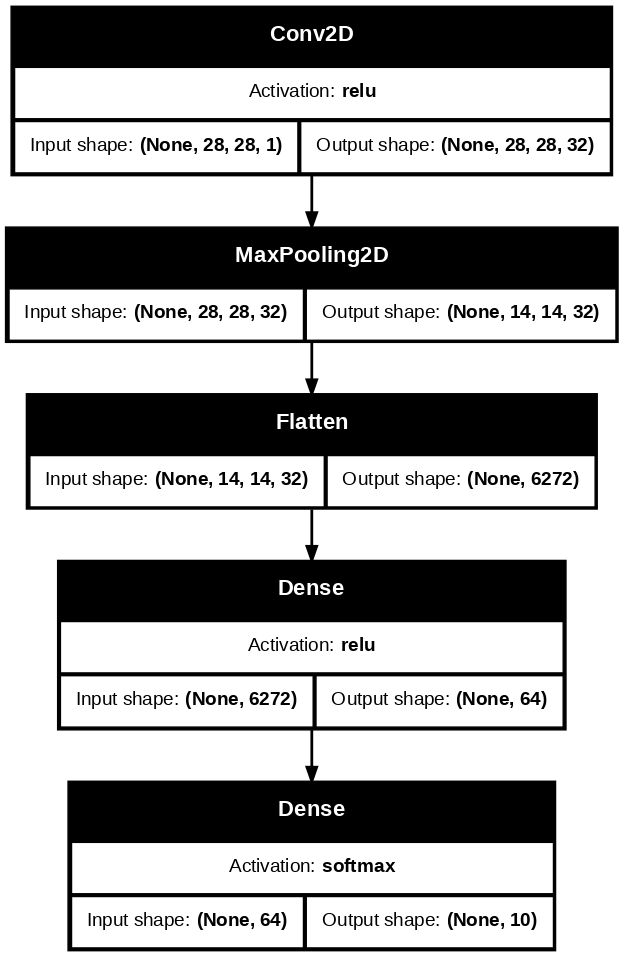

In [ ]:
# Get model summary and architecture
print(baseline_model.summary())
plot_model(
    baseline_model, show_shapes=True, show_layer_activations=True, dpi=100, rankdir="LR"
)

## CNN Model v1

While the baseline performed reasonably well with an accuracy of 83.1%, several enhancements were made to the model architecture to increase its performance.

To capture higher-level features within images, more convolutional layers were added with an increase in the number of filters.

Additionally, batch normalisation was added to stabilise the training process by normalising activations across layers. This helps with faster learning and more stable convergence by mitigating the vanishing/exploding gradient problem.

Dropout layers were also added as a form of regularisation to reduce overfitting of the model, helping with overall generalisation.

Lastly, the penultimate fully-connected layer's neuron count was increased to 256 to allow the model to learn complex relationships between extracted features and target classes.

In [13]:
# CNN model with three convolutional layers and two fully-connected layers
model_v1 = tf.keras.models.Sequential(
    [
        # First Convolutional Block
        tf.keras.layers.Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            input_shape=(28, 28, 1),
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        # Second Convolutional Block
        tf.keras.layers.Conv2D(
            64,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        # Third Convolutional Block
        tf.keras.layers.Conv2D(
            128,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        # Global Average Pooling
        tf.keras.layers.GlobalAveragePooling2D(),
        # Fully Connected Layers
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

# Compile model
model_v1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Log for tensorboard (optional)
current_time = dt.now().strftime("%d %b %Y %H:%M")
log_dir = "logs/model_v1/" + current_time
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Fit model
logger.debug("Training CNN model")
history_v1 = model_v1.fit(
    data_gen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[tb_callback],
)
logger.success("Final CNN model successfully trained!")

2024-11-29 12:35:52.322 | DEBUG    | __main__:<cell line: 63>:63 - Training CNN model


Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.5695 - loss: 1.1747 - val_accuracy: 0.7451 - val_loss: 0.6853
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.7528 - loss: 0.6766 - val_accuracy: 0.7912 - val_loss: 0.5587
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.7796 - loss: 0.6078 - val_accuracy: 0.8303 - val_loss: 0.4636
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.7902 - loss: 0.5651 - val_accuracy: 0.8443 - val_loss: 0.4348
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8044 - loss: 0.5387 - val_accuracy: 0.8468 - val_loss: 0.4249
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.8139 - loss: 0.5132 - val_accuracy: 0.8468 - val_loss: 0.4216
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.8131 - loss: 0.5105 - val_accuracy: 0.8537 - val_loss: 0.4030
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.8206 -

2024-11-29 12:51:03.521 | SUCCESS  | __main__:<cell line: 70>:70 - Final CNN model successfully trained!


In [14]:
# Evaluate model results using tensorbord (optional)
# %tensorboard --logdir logs/model_v1

2024-11-29 12:51:03.538 | DEBUG    | __main__:evaluate_model:16 - Evaluating model...


Test accuracy: 0.88250

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.84      0.85      0.84      1000
           3       0.86      0.88      0.87      1000
           4       0.84      0.77      0.80      1000
           5       0.94      0.97      0.96      1000
           6       0.65      0.71      0.68      1000
           7       0.94      0.92      0.93      1000
           8       0.96      0.98      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



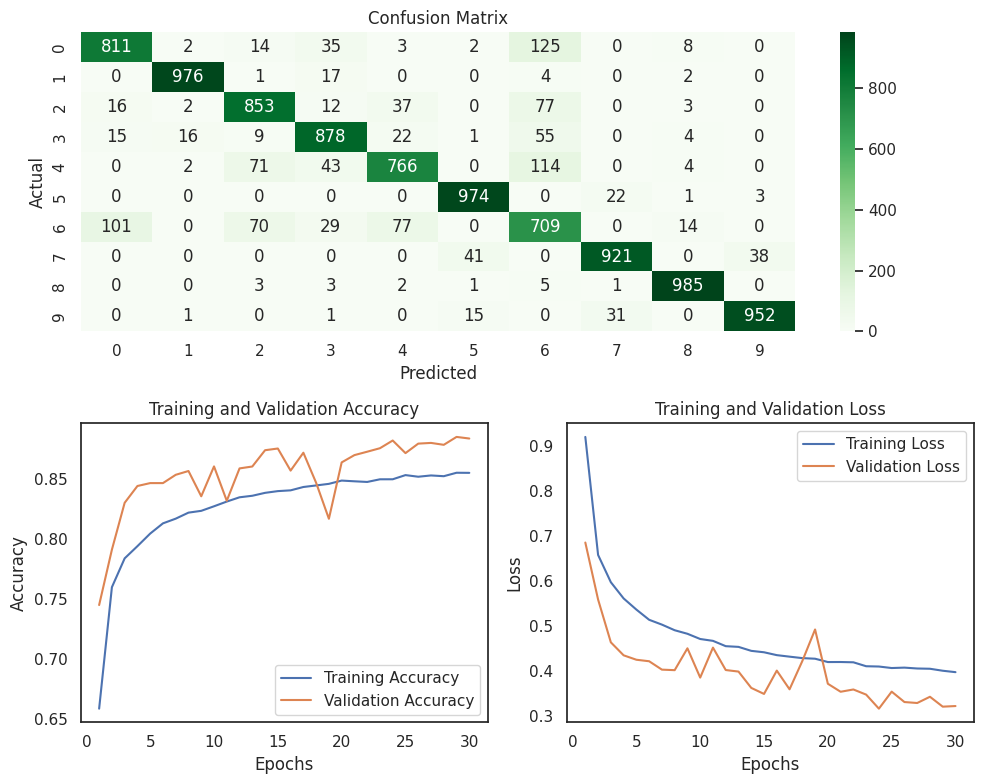

In [15]:
# Evaluate v1
evaluate_model(
    model=model_v1, history=history_v1, x_test=x_test, y_test=y_test, num_classes=10
)

Simply by adding more layers, increasing the number of neurons, and applying regularization techniques, we achieved a 5% improvement in accuracy.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 128)           │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 385,920 (1.47 MB)

 Trainable params: 128,490 (501.91 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 256,982 (1003.84 KB)

None


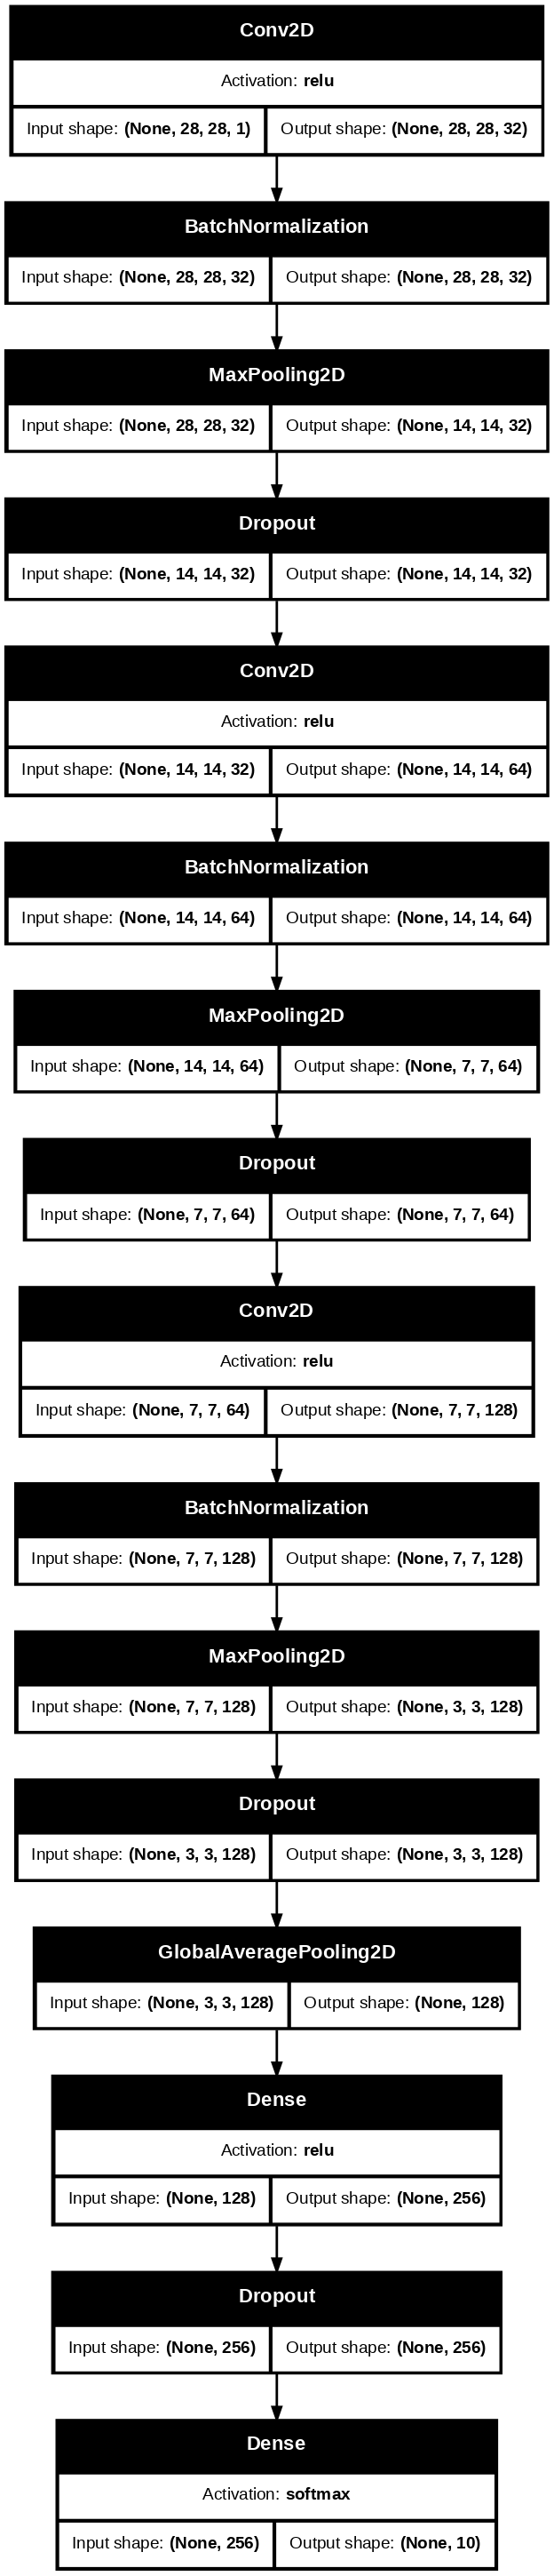

In [ ]:
# Get model summary and architecture
print(model_v1.summary())
plot_model(
    model_v1, show_shapes=True, show_layer_activations=True, dpi=100, rankdir="LR"
)

## CNN Model v2

Experimenting with hyperparameters to improve the model, we reduced the dropout rate (as there is no overfitting) and increased the penultimate layer's neurons to potentially enhance feature extraction and accuracy.

In [17]:
# CNN model with four convolutional layers and two fully-connected layers
# Drop-out for each convolutional layer reduced to 0.1
# Second-last FC layer number of units increased to 512
model_v2 = tf.keras.models.Sequential(
    [
        # First Convolutional Block
        tf.keras.layers.Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            input_shape=(28, 28, 1),
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.1),
        # Second Convolutional Block
        tf.keras.layers.Conv2D(
            64,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.1),
        # Third Convolutional Block
        tf.keras.layers.Conv2D(
            128,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.1),
        # Fourth Convolutional Block
        tf.keras.layers.Conv2D(
            256,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.1),
        # Global Average Pooling
        tf.keras.layers.GlobalAveragePooling2D(),
        # Fully Connected Layers
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

# Compile model
model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Log for tensorboard (optional)
current_time = dt.now().strftime("%d %b %Y %H:%M")
log_dir = "logs/model_v2/" + current_time
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Fit model
logger.debug("Training CNN model")
history_v2 = model_v2.fit(
    data_gen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[tb_callback],
)
logger.success("Final CNN model successfully trained!")

2024-11-29 12:51:10.368 | DEBUG    | __main__:<cell line: 77>:77 - Training CNN model


Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.6071 - loss: 1.0941 - val_accuracy: 0.7810 - val_loss: 0.5741
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.7652 - loss: 0.6359 - val_accuracy: 0.7811 - val_loss: 0.6000
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7946 - loss: 0.5625 - val_accuracy: 0.7903 - val_loss: 0.5466
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8107 - loss: 0.5132 - val_accuracy: 0.8438 - val_loss: 0.4262
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8186 - loss: 0.4958 - val_accuracy: 0.8384 - val_loss: 0.4409
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8329 - loss: 0.4585 - val_accuracy: 0.8490 - val_loss: 0.4070
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8400 - loss: 0.4422 - val_accuracy: 0.8606 - val_loss: 0.3926
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.8381 -

2024-11-29 13:08:09.388 | SUCCESS  | __main__:<cell line: 84>:84 - Final CNN model successfully trained!


In [18]:
# Evaluate model results using tensorbord (optional)
# %tensorboard --logdir logs/model_v2

Model performance improved to 89.3%, suggesting that reducing regularization through dropout and increasing the number of neurons in the fully-connected layer enhanced the model’s ability to differentiate between similar classes, leading to improved predictive accuracy.

2024-11-29 13:08:09.404 | DEBUG    | __main__:evaluate_model:16 - Evaluating model...


Test accuracy: 0.89340

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1000
           1       0.98      0.97      0.98      1000
           2       0.91      0.80      0.85      1000
           3       0.87      0.92      0.89      1000
           4       0.81      0.85      0.83      1000
           5       0.97      0.98      0.98      1000
           6       0.68      0.73      0.71      1000
           7       0.90      0.98      0.94      1000
           8       0.98      0.99      0.98      1000
           9       1.00      0.89      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



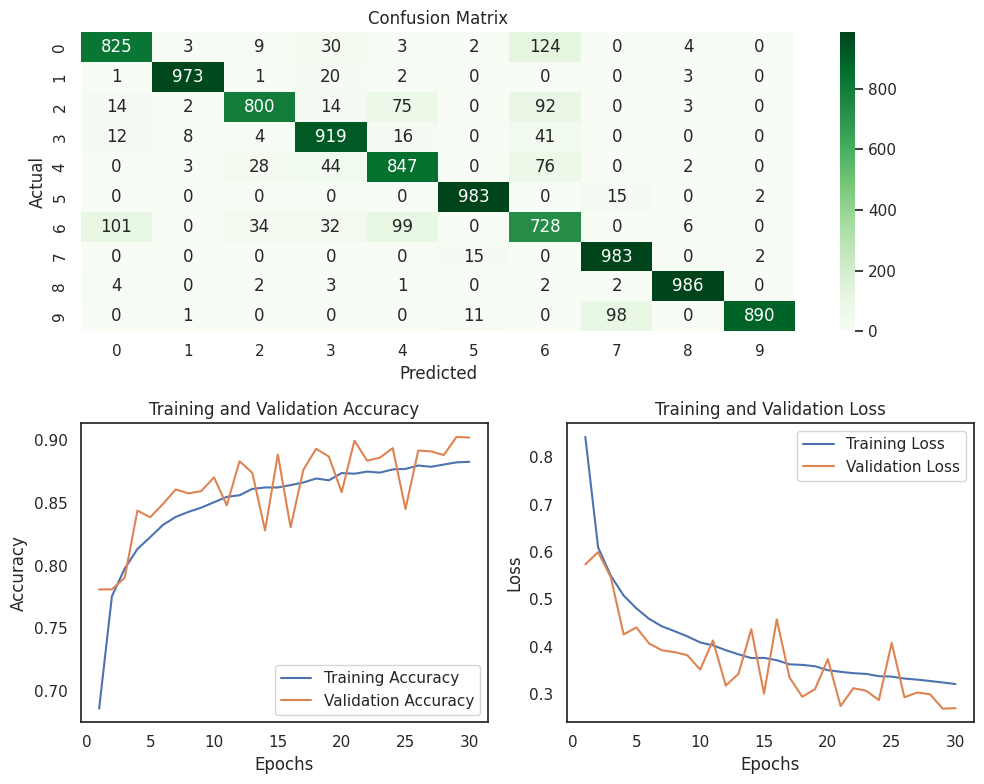

In [19]:
# Evaluate v2
evaluate_model(
    model=model_v2, history=history_v2, x_test=x_test, y_test=y_test, num_classes=10
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 64)          │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 128)           │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 256)           │         294,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │              

 Total params: 1,576,064 (6.01 MB)

 Trainable params: 525,034 (2.00 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,050,070 (4.01 MB)

None


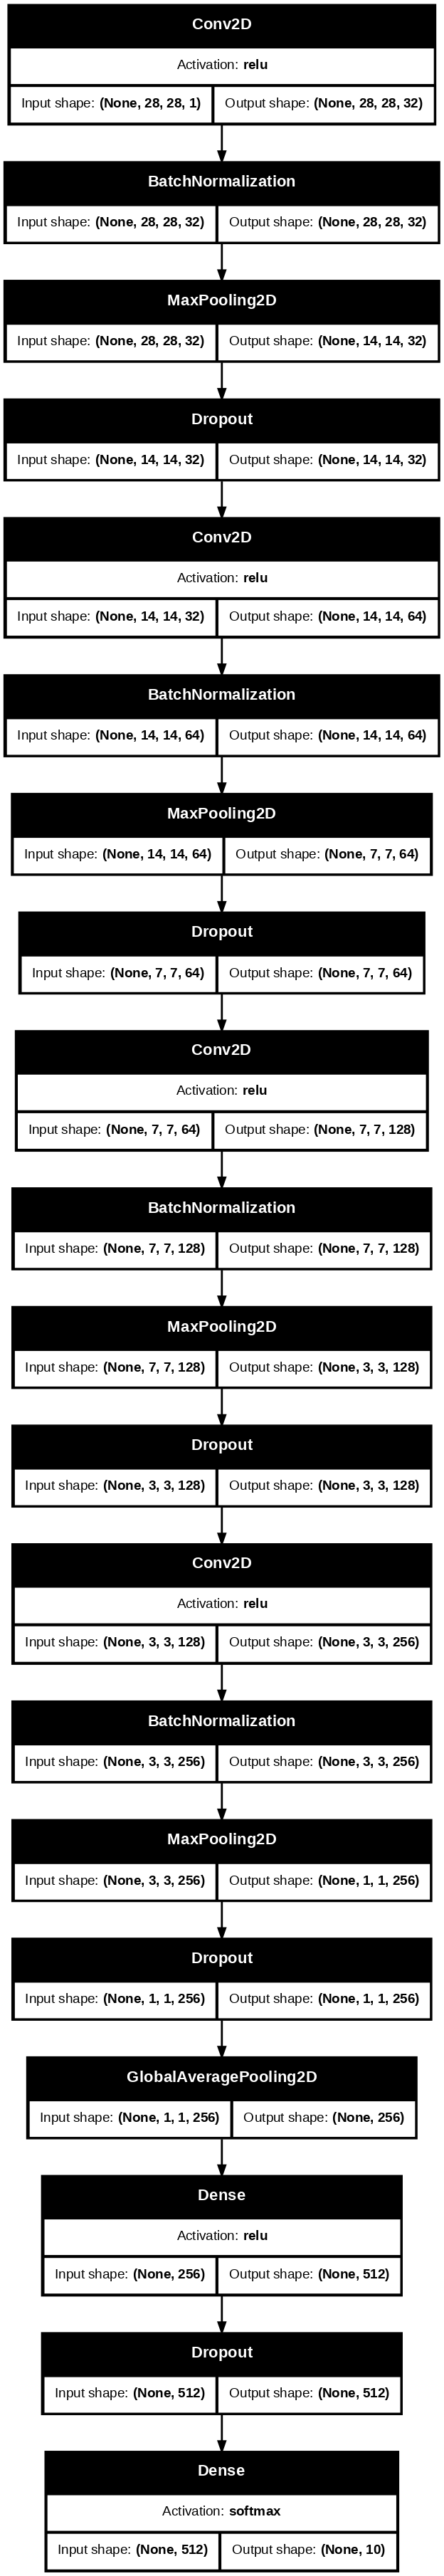

In [ ]:
print(model_v2.summary())
plot_model(
    model_v2, show_shapes=True, show_layer_activations=True, dpi=100, rankdir="LR"
)

# 5. Hyperparameter Tuning <a id='5'><a>

## Selected Model: v2

Since model v2 achieved a higher accuracy of 89.3%, we will focus on hyperparameter tuning to further boost its performance. Specifically, we aim to adjust the batch size and learning rate so as to enhance convergence speed and improve the model’s generalisation, leading to better overall performance.

In [21]:
# Define a model-building function for hyperparameter tuning using keras tuner
def build_model(hp):
    model = tf.keras.models.Sequential(
        [
            # First Convolutional Block
            tf.keras.layers.Conv2D(
                32,
                (3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                padding="same",
                input_shape=(28, 28, 1),
                use_bias=False,
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.1),
            # Second Convolutional Block
            tf.keras.layers.Conv2D(
                64,
                (3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                padding="same",
                use_bias=False,
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.1),
            # Third Convolutional Block
            tf.keras.layers.Conv2D(
                128,
                (3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                padding="same",
                use_bias=False,
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.1),
            # Fourth Convolutional Block
            tf.keras.layers.Conv2D(
                256,
                (3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                padding="same",
                use_bias=False,
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.1),
            # Global Average Pooling
            tf.keras.layers.GlobalAveragePooling2D(),
            # Fully Connected Layers
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])  # Vary learning rate
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# Initialize tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=30,
    factor=3,
    directory="logs",
    project_name="model_tuning",
    overwrite=True,
)

# Log for tensorboard (optional)
current_time = dt.now().strftime("%d %b %Y %H:%M")
log_dir = "logs/model_tuning/" + current_time
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early callback if validation loss does not improve after 5 epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Search for best hyperparameters
logger.debug("Performing hyperparameter tuning")
tuner.search(
    data_gen.flow(
        X_train,
        y_train,
        batch_size=tuner.oracle.hyperparameters.Choice(
            "batch_size", [16, 32, 64]
        ),  # Vary batch size
    ),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[stop_early, tb_callback],
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
logger.success("Best hyperparameters found! Building best model")
tuned_model = tuner.hypermodel.build(best_hps)

# Print best set of hyperparameters
logger.info("Displaying best hyperparameters")
print("\nBest model hyperparameters:")
for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

2024-11-29 13:18:52.277 | SUCCESS  | __main__:<cell line: 110>:110 - Best hyperparameters found! Building best model
2024-11-29 13:18:52.358 | INFO     | __main__:<cell line: 114>:114 - Displaying best hyperparameters


Trial 9 Complete [00h 01m 13s]
val_accuracy: 0.7224166393280029

Best val_accuracy So Far: 0.8309166431427002
Total elapsed time: 00h 10m 38s

Best model hyperparameters:
learning_rate: 0.001
batch_size: 64
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0


__Fit and train tuned model for final evaluation__

In [23]:
# Log for tensorboard (optional)
current_time = dt.now().strftime("%d %b %Y %H:%M")
log_dir = "logs/model_final/" + current_time
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Fit the best model among all candidate models
logger.debug("Training CNN model")
history_tuned = tuned_model.fit(
    data_gen.flow(X_train, y_train, batch_size=64),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[tb_callback],
)
logger.success("Final CNN model successfully trained!")

2024-11-29 13:24:28.494 | DEBUG    | __main__:<cell line: 7>:7 - Training CNN model


Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.8649 - loss: 0.3668 - val_accuracy: 0.8836 - val_loss: 0.3165
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.8691 - loss: 0.3581 - val_accuracy: 0.8935 - val_loss: 0.2882
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.8751 - loss: 0.3432 - val_accuracy: 0.8874 - val_loss: 0.3035
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8751 - loss: 0.3408 - val_accuracy: 0.8839 - val_loss: 0.3115
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8745 - loss: 0.3396 - val_accuracy: 0.8873 - val_loss: 0.3061
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.8783 - loss: 0.3329 - val_accuracy: 0.8932 - val_loss: 0.2905
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8773 - loss: 0.3322 - val_accuracy: 0.8907 - val_loss: 0.2924
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.8758 - loss: 0.3335 - 

2024-11-29 13:35:22.593 | SUCCESS  | __main__:<cell line: 14>:14 - Final CNN model successfully trained!


In [ ]:
# Evaluate model results using tensorbord (optional)
# %tensorboard --logdir logs/model_final

2024-11-29 13:42:55.312 | DEBUG    | __main__:evaluate_model:16 - Evaluating model...


Test accuracy: 0.88200

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.68      0.79      1000
           1       0.99      0.98      0.98      1000
           2       0.95      0.69      0.80      1000
           3       0.86      0.93      0.89      1000
           4       0.82      0.84      0.83      1000
           5       0.94      0.99      0.97      1000
           6       0.59      0.85      0.70      1000
           7       0.94      0.94      0.94      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.94      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.90      0.88      0.88     10000
weighted avg       0.90      0.88      0.88     10000



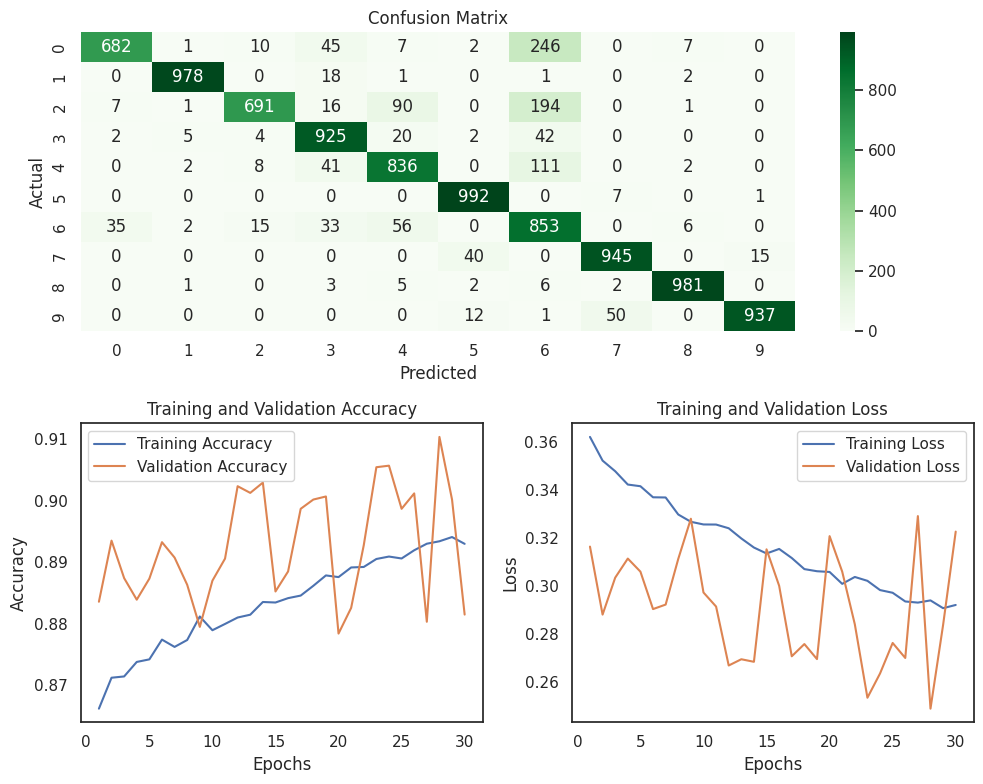

In [24]:
# Evaluate tuned model
evaluate_model(
    model=tuned_model,
    history=history_tuned,
    x_test=x_test,
    y_test=y_test,
    num_classes=10,
)

The final model achieved an accuracy of 88.2%, with a precision of 90% and both recall and F1-score at 88%.

Misclassifications were mainly observed among the following classes: shirts (class 6), T-shirts/tops (class 0), pullovers (class 2), dresses (class 3), sneakers (class 7), and ankle boots (class 9). These errors suggest overlapping features or highly similar patterns across these categories that challenge the model’s ability to distinguish them accurately.

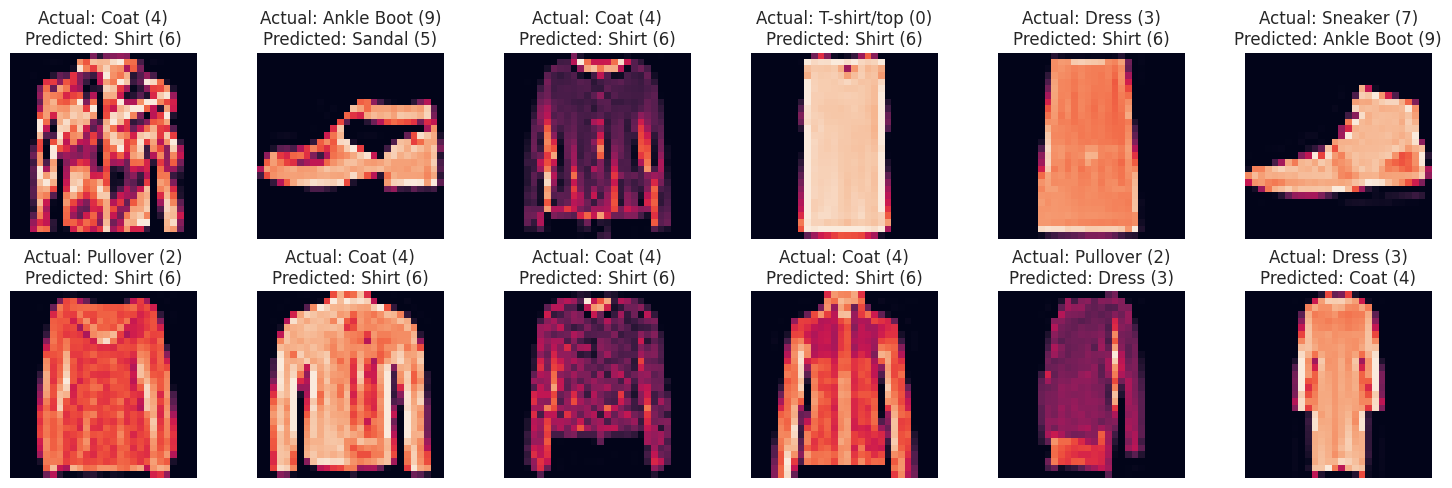

In [25]:
# Generate predictions
y_pred = tuned_model.predict(x_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Identify misclassifications
misclassified_indices = np.where(y_pred_classes != y_test)[0]

# Retrieve misclassified images and their respective labels
x_test_misclassified = x_test[misclassified_indices]
y_test_misclassified = y_test[misclassified_indices]
y_pred_misclassified = y_pred_classes[misclassified_indices]

# Plot first few images for inspection
plt.figure(figsize=(15, 5))
sns.set_theme(style="white")

for i in range(12):
    plt.subplot(2, 6, i + 1)
    image = x_test_misclassified[i]
    plt.imshow(image)
    plt.title(
        f"Actual: {labels[y_test_misclassified[i]]} ({y_test_misclassified[i]})\nPredicted: {labels[y_pred_misclassified[i]]} ({y_pred_misclassified[i]})"
    )
    plt.axis("off")

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

# 6. Conclusion <a id='6'></a>

Using a CNN model with tuned hyperparameters, we achieved an accuracy of 88.2% which is a 1% decrease compared to our v2 model. This slight drop may reflect the model’s improved generalizability, resulting in a minor reduction in test set performance.

Nonetheless, to further improve test accuracy and refine the model, future efforts can focus on:
- __Data Augmentation__: Targeting images from underperforming classes to improve class-specific accuracy.
- __Network Architecture__: Expanding the number of layers and filters to better capture complex patterns (e.g., long-sleeved shirts) and identifying the optimal model depth.
- __Hyperparameter Tuning__: Exploring additional hyperparameters, such as dropout rate for regularization strength, number of epochs, neurons in dense layers, and optimizer selection, in addition to learning rate and batch size explored in this analysis.
- __Systematic Experimentation__: Establishing a more structured and systematic framework for model development and testing to ensure consistent improvements.